In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_info = pd.read_csv('https://raw.githubusercontent.com/dpn29/Lending-club-project/master/lending_club_info.csv',
                        index_col='LoanStatNew')
def feat_info(col_name):
    print(data_info.loc[col_name]['Description'])

In [3]:
urls = ['https://raw.githubusercontent.com/dpn29/Lending-club-project/master/data'+str(i)+'.csv' for i in range(5)]
df = pd.read_csv(urls[0])
for i in range(1,5):
  df = pd.concat([df, pd.read_csv(urls[i])],ignore_index=True)
df = df.drop('Unnamed: 0',axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

## Explanatory data analysis

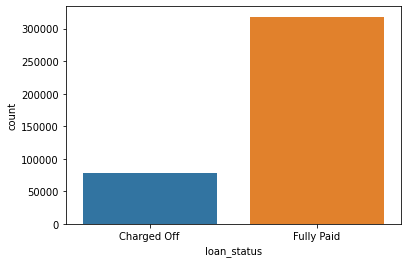

In [4]:
sns.countplot(df['loan_status'])

We have unbalanced classes.

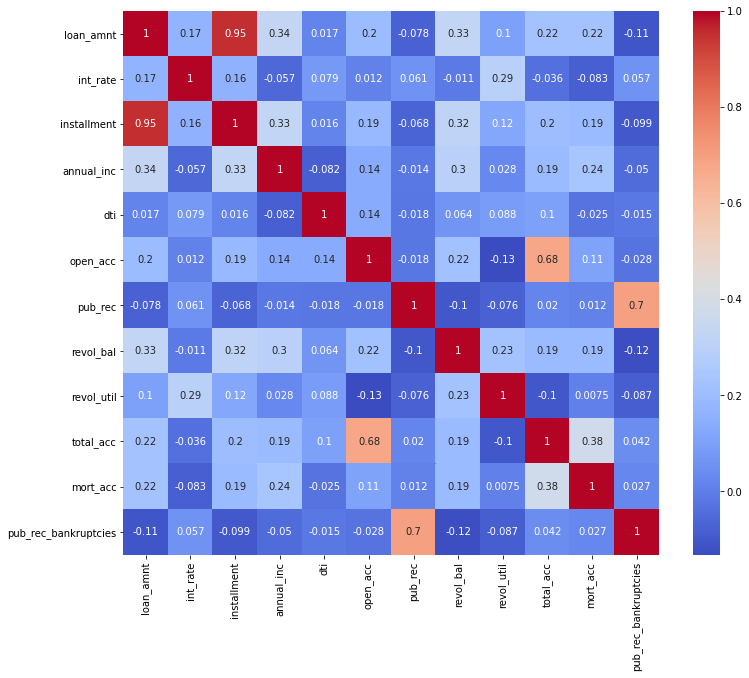

In [5]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')

In [6]:
feat_info('installment')
print('\n')
feat_info('loan_amnt')

The monthly payment owed by the borrower if the loan originates.


The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


Seems like installment is calculated based on the loan amount (makes sense) but no duplicate data, so leave both columns in.

In [7]:
print(sorted(list(df['grade'].unique())))
print(sorted(list(df['sub_grade'].unique())))

['A', 'B', 'C', 'D', 'E', 'F', 'G']
['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The subgrade contains the grade, so drop grade.

In [8]:
df = df.drop('grade',axis=1)

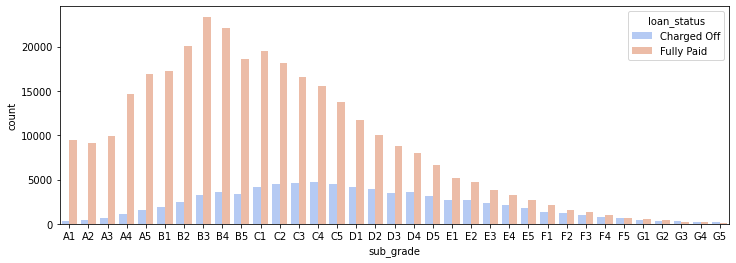

In [9]:
plt.figure(figsize=(12,4))
sns.countplot(x='sub_grade',data=df,hue='loan_status',order=sorted(list(df['sub_grade'].unique())),palette='coolwarm')

Seems like the loan grade is a useful predictor, will turn into numerical variables.

Turn the target column to numerical.

In [10]:
df['loan_repaid'] = df['loan_status'].apply(lambda x: 1 if x=='Fully Paid' else 0)

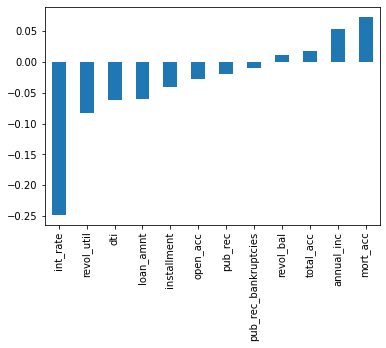

In [11]:
df.corr()['loan_repaid'][:-1].sort_values().plot.bar()

## Data preprocessing

In [12]:
df.isnull().sum()/df.shape[0]*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

Some missing data issues but not terrible. Let's proceed from top to bottom.

In [13]:
df['emp_title'].value_counts()

Teacher                            4389
Manager                            4250
Registered Nurse                   1856
RN                                 1846
Supervisor                         1830
                                   ... 
Manufacturing/ Quality Engineer       1
Hudgins Family Properties LLC         1
Business software specialist          1
Greenstein & Associates               1
Kitsap Mental Health                  1
Name: emp_title, Length: 173105, dtype: int64

Too many unique values and missing for almost 6% of observations. Drop this column.

In [14]:
df = df.drop('emp_title',axis=1)

In [15]:
df['emp_length'].value_counts()

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64

In [16]:
default_prob_per_emp_lenth = df[df['loan_repaid']==0].groupby('emp_length')['loan_status'].count() / df.groupby('emp_length')['loan_status'].count()

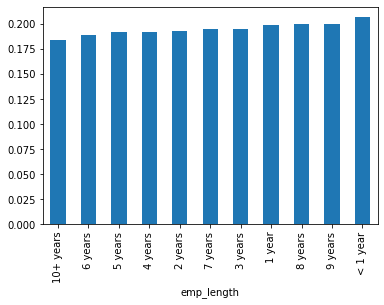

In [17]:
default_prob_per_emp_lenth.sort_values().plot.bar()

Having 10+ years of employment and having <1 year seem to contain useful information while durations inbetween seem randomly ordered. Encode this variable with 3 dummies (to also indicate if the data was missing).

In [18]:
df['nan_emp'] = df['emp_length'].isnull().apply(int)
df['long_emp'] = df['emp_length'].apply(lambda x: 1 if x=='10+ years' else 0)
df['short_emp'] = df['emp_length'].apply(lambda x: 1 if x=='< 1 year' else 0)
df[['emp_length','long_emp','short_emp','nan_emp']].head(10)

,emp_length,long_emp,short_emp,nan_emp
0,2 years,0,0,0
1,5 years,0,0,0
2,3 years,0,0,0
3,3 years,0,0,0
4,6 years,0,0,0
5,7 years,0,0,0
6,< 1 year,0,1,0
7,10+ years,1,0,0
8,1 year,0,0,0
9,3 years,0,0,0


In [19]:
df = df.drop('emp_length',axis=1)

In [20]:
df['title'].value_counts()

Debt consolidation         152472
Credit card refinancing     51487
Home improvement            15264
Other                       12930
Debt Consolidation          11608
                            ...  
Persona Loan #2                 1
jmls                            1
Pay off, be DONE                1
window coverings                1
get out of card debt            1
Name: title, Length: 48817, dtype: int64

In [21]:
feat_info('title')

The loan title provided by the borrower


Likely to contain useful info but needs domain experience or NLP to encode; just drop it now.

In [22]:
df = df.drop('title',axis=1)

In [23]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
25.0         4
21.0         4
27.0         3
26.0         2
23.0         2
32.0         2
31.0         2
30.0         1
34.0         1
28.0         1
Name: mort_acc, dtype: int64

In [24]:
feat_info('mort_acc')

Number of mortgage accounts.


In [25]:
df.corr()['mort_acc'].sort_values()

int_rate               -0.082583
short_emp              -0.067058
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
nan_emp                 0.017617
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
long_emp                0.196780
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [26]:
feat_info('total_acc')

The total number of credit lines currently in the borrower's credit file


Let's impute mort_acc based on total_acc. total_acc is never missing.

In [27]:
mort_from_total = df.groupby('total_acc')['mort_acc'].mean()
mort_acc = list(df['mort_acc'].isnull())
for i in range(df.shape[0]):
    if mort_acc[i]:
        mort_acc[i] = mort_from_total[df['total_acc'][i]]
    else:
        mort_acc[i] = df['mort_acc'][i]
df['mort_acc'] = mort_acc

revol_util and the pub_rec_bankruptcies have missing data points, but they account for less than 0.2% of the total data, so just drop the rows with missing data.

In [28]:
df = df.dropna(axis=0)

In [29]:
print(df.shape[0])
df.isnull().sum()

395219


loan_amnt               0
term                    0
int_rate                0
installment             0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
nan_emp                 0
long_emp                0
short_emp               0
dtype: int64

Turn to dealing with non-numeric features.

In [30]:
df.select_dtypes(include=object).columns

Index(['term', 'sub_grade', 'home_ownership', 'verification_status', 'issue_d',
       'loan_status', 'purpose', 'earliest_cr_line', 'initial_list_status',
       'application_type', 'address'],
      dtype='object')

In [31]:
df['term'].value_counts().index

Index([' 36 months', ' 60 months'], dtype='object')

In [32]:
df['term'] = df['term'].apply(lambda x: 36 if x==' 36 months' else 60)

In [33]:
feats = ['sub_grade','verification_status','application_type','initial_list_status','purpose']
for feat in feats:
    print(df[feat].value_counts())

B3    26611
B4    25558
C1    23609
C2    22541
B2    22457
B5    22046
C3    21178
C4    20232
B1    19140
A5    18500
C5    18215
D1    15947
A4    15763
D2    13916
D3    12196
D4    11625
A3    10537
A1     9717
D5     9680
A2     9539
E1     7906
E2     7410
E3     6196
E4     5354
E5     4561
F1     3530
F2     2756
F3     2277
F4     1782
F5     1395
G1     1057
G2      752
G3      552
G4      371
G5      313
Name: sub_grade, dtype: int64
Verified           139451
Source Verified    131301
Not Verified       124467
Name: verification_status, dtype: int64
INDIVIDUAL    394508
JOINT            425
DIRECT_PAY       286
Name: application_type, dtype: int64
f    237346
w    157873
Name: initial_list_status, dtype: int64
debt_consolidation    234169
credit_card            82923
home_improvement       23961
other                  21059
major_purchase          8756
small_business          5656
car                     4670
medical                 4175
moving                  2842
vacatio

These features look worthwhile to turn into dummy variables.

In [34]:
for feat in feats:
    df = pd.concat([df.drop(feat,axis=1),pd.get_dummies(df[feat],drop_first=True)],axis=1)
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'issue_d', 'loan_status', 'dti', 'earliest_cr_line',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'mort_acc', 'pub_rec_bankruptcies', 'address', 'loan_repaid', 'nan_emp',
       'long_emp', 'short_emp', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4',
       'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1',
       'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3',
       'G4', 'G5', 'Source Verified', 'Verified', 'INDIVIDUAL', 'JOINT', 'w',
       'credit_card', 'debt_consolidation', 'educational', 'home_improvement',
       'house', 'major_purchase', 'medical', 'moving', 'other',
       'renewable_energy', 'small_business', 'vacation', 'wedding'],
      dtype='object')

In [35]:
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

Too few observations in the NONE and ANY categories, hard to interpret anyways. Lump there under OTHER

In [36]:
df['home_ownership'] = df['home_ownership'].apply(lambda x: x if x in ['MORTGAGE','RENT','OWN'] else 'OTHER')
df = pd.concat([df.drop('home_ownership',axis=1),pd.get_dummies(df['home_ownership'],drop_first=True)],axis=1)

In [37]:
df['address']

0         68264 Hamilton Harbors Apt. 149\nSouth Karl, O...
1                          PSC 1462, Box 1404\nAPO AP 70466
2              63177 Marc Orchard\nPort Charlotte, NY 70466
3         7027 Benjamin Freeway Suite 978\nSouth Katheri...
4         3182 Roach Island Suite 434\nElizabethville, N...
                                ...                        
396025    5496 Elijah Locks Suite 248\nJasonville, SD 70466
396026    39275 Lara Ports Suite 055\nSouth Terrichester...
396027    8911 Miller Village Apt. 743\nLake Amanda, FL ...
396028       00038 James Square\nPort Patrickside, RI 30723
396029            39726 Ward Common\nJameschester, AL 00813
Name: address, Length: 395219, dtype: object

There are too many addresses, but we can use the zip codes!

In [38]:
df['zip_code'] = df['address'].apply(lambda x: x[-8:])
df['zip_code'].value_counts()

AP 70466    2162
AE 22690    2103
AP 22690    2087
AE 48052    2023
AA 22690    2015
            ... 
NH 86630     167
NC 93700     167
NM 11650     166
UT 86630     163
ND 93700     158
Name: zip_code, Length: 540, dtype: int64

This requires 539 dummies, which is quite a lot but we also have a lot of data. But a meaningful amount of observation in each category. Makes dummies, but give them an identifiable name to train the model with and without these. Also make dummies for each state.

In [39]:
df['state'] = df['zip_code'].apply(lambda x: x[:2])
df['state'].value_counts()

AP    14269
AE    14124
AA    13890
NJ     7076
WI     7066
LA     7048
AK     7026
NV     7022
MA     7014
VA     7007
VT     6991
NY     6988
MS     6986
TX     6977
OH     6965
SC     6959
AR     6958
GA     6955
ME     6953
ID     6945
IN     6942
MO     6934
KS     6934
RI     6927
WV     6925
WY     6922
IL     6921
HI     6920
NE     6914
FL     6906
CO     6900
IA     6900
OK     6900
AZ     6897
MN     6895
CA     6889
CT     6887
AL     6886
NC     6886
OR     6885
MD     6883
WA     6877
UT     6876
SD     6872
MT     6865
DE     6861
TN     6859
ND     6846
MI     6835
DC     6829
NM     6829
PA     6815
NH     6804
KY     6779
Name: state, dtype: int64

(The three military mail codes are far more common than any state.)

In [40]:
df = pd.concat([df.drop(['zip_code','address','state'],axis=1),
                pd.get_dummies(df['zip_code'],drop_first=True,prefix='ZIP'),
                pd.get_dummies(df['state'],drop_first=True,prefix='STATE')],
               axis=1)

In [41]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'issue_d',
       'loan_status', 'dti', 'earliest_cr_line', 'open_acc',
       ...
       'STATE_SD', 'STATE_TN', 'STATE_TX', 'STATE_UT', 'STATE_VA', 'STATE_VT',
       'STATE_WA', 'STATE_WI', 'STATE_WV', 'STATE_WY'],
      dtype='object', length=667)

In [42]:
feat_info('issue_d')

The month which the loan was funded


Using issue_d would be data leakage (when receiving the application, we don't know which if any month it will be issued in).

In [43]:
df = df.drop('issue_d',axis=1)

In [44]:
df['earliest_cr_line'].value_counts()

Oct-2000    3013
Aug-2000    2930
Oct-2001    2890
Aug-2001    2879
Nov-2000    2729
            ... 
Dec-1950       1
Nov-1961       1
Nov-1953       1
Jan-1944       1
Nov-1955       1
Name: earliest_cr_line, Length: 684, dtype: int64

This is too many dummies. Let's just use the year as it may contain useful information.

In [45]:
df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda x: x[-4:])
df.drop('earliest_cr_line',axis=1,inplace=True)
df['earliest_cr_year'] = df['earliest_cr_year'].apply(int)

Drop loan_status as we've already converted it.

In [46]:
df.drop('loan_status',axis=1,inplace=True)

In [47]:
print(df.select_dtypes(include=object).columns)
df.isnull().sum().sum()

Index([], dtype='object')


0

Seems like the data is clean, we are ready to go!

## Modeling

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
zip_cols = [column for column in df.columns if 'ZIP_' in column]
state_cols = [column for column in df.columns if 'STATE_' in column]

In [50]:
y = df['loan_repaid'].values
X_zip = df.drop(['loan_repaid']+state_cols,axis=1).values
X_state = df.drop(['loan_repaid']+zip_cols,axis=1).values
X = df.drop(['loan_repaid']+state_cols+zip_cols,axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Let's look for outliers before deciding how to scale the data.

In [51]:
non_dummy_columns = []
for column in df.columns:
    if ('ZIP_' in column) or ('STATE_' in column):
        continue
    for i in df[column][:100]:
        if i not in [0,1]:
            non_dummy_columns.append(column)
            break

In [52]:
pd.DataFrame(X_train, columns=df.drop(['loan_repaid']+state_cols+zip_cols,axis=1).columns)[non_dummy_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,276653.0,14125.381525,8360.485279,500.00,8000.00,12000.00,20000.00,40000.00
term,276653.0,41.697303,10.211581,36.00,36.00,36.00,36.00,60.00
int_rate,276653.0,13.644266,4.475986,5.32,10.49,13.33,16.55,30.99
installment,276653.0,432.236352,250.795872,16.08,250.52,375.43,568.64,1527.00
annual_inc,276653.0,74170.629765,60295.891230,0.00,45000.00,64000.00,90000.00,7600000.00
dti,276653.0,17.414082,20.880067,0.00,11.31,16.92,22.99,9999.00
open_acc,276653.0,11.315229,5.125051,1.00,8.00,10.00,14.00,90.00
pub_rec,276653.0,0.178111,0.517051,0.00,0.00,0.00,0.00,40.00
revol_bal,276653.0,15852.446353,20318.556497,0.00,6047.00,11210.00,19649.00,1190046.00
revol_util,276653.0,53.840737,24.390336,0.00,35.90,54.90,72.90,153.00


Some features contain outliers. Let's use RobustScaler to make the interquartile range equal 1, without dropping the outliers.

In [53]:
from sklearn.preprocessing import RobustScaler

In [54]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [55]:
pd.DataFrame(X_train, columns=df.drop(['loan_repaid']+state_cols+zip_cols,axis=1).columns)[non_dummy_columns].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,276653.0,0.177115,0.696707,-0.958333,-0.333333,0.0,0.666667,2.333333
term,276653.0,5.697303,10.211581,0.000000,0.000000,0.0,0.000000,24.000000
int_rate,276653.0,0.051859,0.738611,-1.321782,-0.468647,0.0,0.531353,2.914191
installment,276653.0,0.178569,0.788369,-1.129605,-0.392651,0.0,0.607349,3.619923
annual_inc,276653.0,0.226014,1.339909,-1.422222,-0.422222,0.0,0.577778,167.466667
dti,276653.0,0.042302,1.787677,-1.448630,-0.480308,0.0,0.519692,854.630137
open_acc,276653.0,0.219205,0.854175,-1.500000,-0.333333,0.0,0.666667,13.333333
pub_rec,276653.0,0.178111,0.517051,0.000000,0.000000,0.0,0.000000,40.000000
revol_bal,276653.0,0.341306,1.493792,-0.824144,-0.379577,0.0,0.620423,86.666373
revol_util,276653.0,-0.028629,0.659198,-1.483784,-0.513514,0.0,0.486486,2.651351


Want to be able to choose whether to drop location data, use states or use ZIP codes.

In [56]:
def set_location(option):
  global X_train, X_test, Y_train, Y_test
  scaler = RobustScaler()

  if option=='base':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
  if option=='state':
    X_train, X_test, y_train, y_test = train_test_split(X_state, y, test_size=0.3, random_state=0)
  if option=='zip':
    X_train, X_test, y_train, y_test = train_test_split(X_zip, y, test_size=0.3, random_state=0)

  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

A random forest model.

In [58]:
def forest_base():
  param_grid = {'max_features':[0.5],'max_depth':[5,10]}
  grid = GridSearchCV(RandomForestClassifier(n_estimators=30,bootstrap=True,max_samples=1000,n_jobs=-1),param_grid,verbose=3)
  grid.fit(X_train,y_train)
  print(grid.best_params_)
  preds = grid.predict(X_test)
  print(classification_report(y_test,preds))

A neural network.

In [59]:
def nn_base():
  model = Sequential()

  model.add(Dense(78,  activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(39, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(19, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(units=1,activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam')

  model.fit(x=X_train, 
          y=y_train, 
          epochs=5,
          batch_size=256,
          validation_data=(X_test, y_test))
  
  losses = pd.DataFrame(model.history.history)
  losses[['loss','val_loss']].plot()

  preds = model.predict_classes(X_test)
  print(classification_report(y_test,preds))
  print(confusion_matrix(y_test,preds))

Epoch 1/5
1081/1081 [==============================] - 6s 6ms/step - loss: 0.3325 - val_loss: 0.2649
Epoch 2/5
1081/1081 [==============================] - 6s 5ms/step - loss: 0.2659 - val_loss: 0.2623
Epoch 3/5
1081/1081 [==============================] - 6s 6ms/step - loss: 0.2610 - val_loss: 0.2603
Epoch 4/5
1081/1081 [==============================] - 6s 6ms/step - loss: 0.2581 - val_loss: 0.2603
Epoch 5/5
1081/1081 [==============================] - 9s 8ms/step - loss: 0.2566 - val_loss: 0.2614
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.95      0.45      0.61     23343
           1       0.88      0.99      0.93     9522

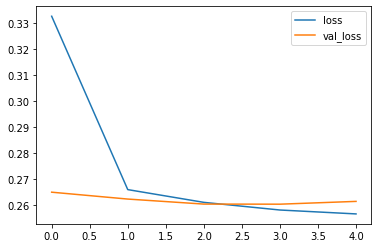

In [60]:
set_location('zip')
nn_base()

If this model was used, giving out ~37k loans that would default could have been prevented at the cost of not giving out ~4.4k loans that would have been repaid (assuming training data existed). This would have saved a lot of money and is a remarkable result since which loans were approved and which were rejected must have already depended on someone's judgement about credit quality.